In [11]:
import numpy as np
import matplotlib.pyplot as plt

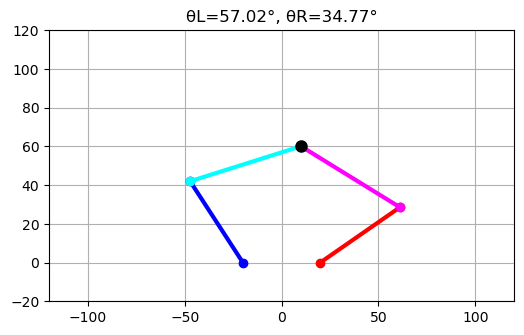

In [1]:
#順運動をする(角度を与えるとx,yの座標を返す)

import numpy as np

def compute_first_link(theta_l_deg, theta_r_deg, l1=50.0, d=40.0, theta_min=10.0):
    """
    θ_l, θ_r から左右の第一関節先端座標を返す。
    描画はしない。
    """

    # --- 角度制限 ---
    if abs(theta_l_deg) > 180:
        print(f"❌ ERROR: 左腕が180°を超えています（θL={theta_l_deg}°）")
        return None, None

    if abs(theta_r_deg) > 180:
        print(f"❌ ERROR: 右腕が180°を超えています（θR={theta_r_deg}°）")
        return None, None

    # --- 干渉判定（あなたの条件） ---
    if (180 - theta_l_deg) <= (theta_r_deg + theta_min):
        print("❌ ERROR: 干渉しています（第一リンクが交差）")
        return None, None

    tl = np.radians(theta_l_deg)
    tr = np.radians(theta_r_deg)

    M_L = np.array([-d/2, 0.0])
    M_R = np.array([ d/2, 0.0])

    L_tip = np.array([
        -d/2 + (-l1 * np.cos(tl)),
         0   + ( l1 * np.sin(tl))
    ])

    R_tip = np.array([
         d/2 + ( l1 * np.cos(tr)),
         0   + ( l1 * np.sin(tr))
    ])

    return L_tip, R_tip


def compute_pen_position(L_tip, R_tip, l2):
    """
    第二リンクの円×円の交点からペン位置を求める。
    描画はしない。
    """

    if L_tip is None or R_tip is None:
        print("❌ ERROR: 第一リンクの計算が失敗")
        return None

    x1, y1 = L_tip
    x2, y2 = R_tip

    d = np.hypot(x2 - x1, y2 - y1)

    # 0点 → ちぎれ判定
    if d > 2 * l2:
        print("❌ ERROR: 第二リンクが届かない（交点0）")
        return None

    if d < 1e-6:
        print("❌ ERROR: 中心が重なりすぎ（不正）")
        return None

    # 接点1つ
    if abs(d - 2*l2) < 1e-6:
        return np.array([(x1+x2)/2, (y1+y2)/2])

    # 交点2つ
    a = d / 2
    h = np.sqrt(l2**2 - a**2)

    xm = x1 + (x2-x1) * a / d
    ym = y1 + (y2-y1) * a / d

    rx = -(y2 - y1) * (h / d)
    ry =  (x2 - x1) * (h / d)

    p1 = np.array([xm + rx, ym + ry])
    p2 = np.array([xm - rx, ym - ry])

    return p1 if p1[1] >= p2[1] else p2

import matplotlib.pyplot as plt

def plot_full_arm(theta_l_deg, theta_r_deg, l1=50, l2=60, d=40):
    """
    θ_l, θ_r から第一リンクと第二リンクを描写する統合関数。
    """

    # --- 第一リンクの先端を取得 ---
    L_tip, R_tip = compute_first_link(theta_l_deg, theta_r_deg, l1=l1, d=d)

    if L_tip is None:
        return

    # --- 第二リンクのペン位置を取得 ---
    P = compute_pen_position(L_tip, R_tip, l2)

    if P is None:
        return

    # --- 描画開始 ---
    plt.figure(figsize=(6,6))
    ax = plt.gca()
    ax.set_aspect("equal")
    ax.set_xlim(-120, 120)
    ax.set_ylim(-20, 120)
    ax.grid(True)

    M_L = np.array([-d/2, 0.0])
    M_R = np.array([ d/2, 0.0])

    # 第一リンク
    ax.plot([M_L[0], L_tip[0]], [M_L[1], L_tip[1]], "o-", lw=3, color="blue")
    ax.plot([M_R[0], R_tip[0]], [M_R[1], R_tip[1]], "o-", lw=3, color="red")

    # 第二リンク
    ax.plot([L_tip[0], P[0]], [L_tip[1], P[1]], "o-", lw=3, color="cyan")
    ax.plot([R_tip[0], P[0]], [R_tip[1], P[1]], "o-", lw=3, color="magenta")

    # ペン位置
    ax.plot(P[0], P[1], "ko", markersize=8)

    plt.title(f"θL={theta_l_deg}°, θR={theta_r_deg}°")
    plt.show()



plot_full_arm(57.02, 34.77, l1=50, l2=60, d=40)



ToGPT
## 一本目の腕
うまくいっていません。一旦順運動学のコードを完璧に仕上げます。私の指示したコードを書いてください。関数としてθ_l,θ_rを受け取る。関数内にl_1(両方の第一関節までの腕の長さ)、d(モーター間距離)を準備する。モーターを(-d/2,0),(d/2,0)に配置、(-d/2,0)のモーターについては(-d/2,0)から((-l_1cosθ_l) - d/2,l_1sinθ_l)までを１番目の腕とする,(d/2,0)から((l_1cosθ_r) + d/2,l_1sinθ_r)までを二本目の腕とする。これをmatplotlibで描写する。2本の腕がd_minよりも近くなってしまう角度が設定されてしまった場合、printでエラーを出して。

このコードに改良を求める。2本の腕がd_minよりも近くなってしまう角度が設定されてしまった場合、printでエラーを出して。このアルゴリズムを変更して、
    # --- 距離チェック ---
    tip_dist = np.linalg.norm(L_tip - R_tip)
    if tip_dist < d_min:
        print(f"❌ ERROR: 先端距離 {tip_dist:.2f} mm < d_min {d_min} mm")
        return
を(180-θl)>θ_r　 + th_minでなければprintでエラー　出力部はここだけでいい

不自然な原因がわかりました。どちらかのアーム180度以上回った時により厳しい基準で判定する様にして(あなたの出力は変更箇所だけで良い)

θ_l,θ_rについて180度以上に回っちゃダメと言う制限を追加、回った場合はエラーを起こす、して、

## 2本目の腕
2本目の腕の作成に移ります。関数にl_2を追加してください(左右に2本目の腕の長さです),simulate_single_linkで求めた両腕の先からペンまでの腕を描写するコードを書いてください。ペンでl_2の先が重なります。
アルゴリズムは任せますが、次のようなアルゴリズムはどうでしょうか？simulate_single_linkで求めた２つの腕の先から半径l_2の円を描く、
円が0点で重なる場合、
腕がちぎれていると判定し、エラーをprintで出す
円が一点で重なる場合
そこが二つのl_2が交わるところ(ペンの位置)とする
円が２点で重なる場合
y座標が上に来るものがペンの位置にする

これ以外のアルゴリズムを採用する場合はコードを書かず、私に数式で説明してください。
このアルゴリズムを採用する場合は、simulate_single_linkを適切な名前、内容(pltの部分は全部いらないよね)に直した後、2本目の腕の作成から呼び出す感じで使ってください。(関数を一つにまとめないこと)

2本目の腕にはpltする機能をつけてくださいよ
2本目の腕を求める関数からpltする機能を省いてください。その代わり、角度を与えると1本目と2本目のうでを描写する関数を呼び出して、二つを書く関数を新たに書いてください

In [35]:
def ik_candidates(x, y, l1=50.0, l2=60.0, d=40.0):
    """
    ペン先位置 (x, y) を与えると
    左右の角度候補 (θL, θR) の組み合わせを返す。
    角度制限・干渉チェックはここでは行わない（純粋に候補だけ）。
    """

    candidates = []

    # =======================================
    #  左側アーム（θL）の候補を求める
    # =======================================
    XL = x + d/2
    YL = y
    rL = np.hypot(XL, YL)

    # K_L の計算
    KL = (l2**2 - l1**2 - rL**2) / (2 * l1)

    left_solutions = []
    if abs(KL / rL) <= 1.0:
        deltaL = np.arctan2(-YL, XL)
        phiL = np.arccos(KL / rL)

        # 2解
        left_solutions.append(deltaL + phiL)
        left_solutions.append(deltaL - phiL)
    else:
        # 解なし
        return []

    # ラジアン→度
    left_solutions = [np.degrees(t) for t in left_solutions]


    # =======================================
    #  右側アーム（θR）の候補を求める
    # =======================================
    XR = x - d/2
    YR = y
    rR = np.hypot(XR, YR)

    # K_R の計算
    KR = (l1**2 + rR**2 - l2**2) / (2 * l1)

    right_solutions = []
    if abs(KR / rR) <= 1.0:
        deltaR = np.arctan2(YR, XR)
        phiR = np.arccos(KR / rR)

        # 2解
        right_solutions.append(deltaR + phiR)
        right_solutions.append(deltaR - phiR)
    else:
        # 解なし
        return []

    # ラジアン→度
    right_solutions = [np.degrees(t) for t in right_solutions]


    # =======================================
    #  左2解 × 右2解 の最大4組を返す
    # =======================================
    for thL in left_solutions:
        for thR in right_solutions:
            candidates.append( (thL, thR) )

    return candidates


cands = ik_candidates(10, 60, l1=50, l2=60, d=40)

for thL, thR in cands:
    print(f"θL={thL:.2f}°, θR={thR:.2f}°")

θL=57.02°, θR=164.16°
θL=57.02°, θR=34.77°
θL=-183.89°, θR=164.16°
θL=-183.89°, θR=34.77°


次に逆運動学を考えます。一旦コードを一切書かず、どの様な計算をすればx,yから二つのモーター角度を割り出せるかを導き方も合わせて数式で書いてみてください。
特に問題なさそうなので、あなたが言ったアルゴリズムを採用します。x,yを与えると、角度の候補の組みが出てくるコードを書いてください